# Comparing datasets

In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
#from skimage import io 
from skimage.io import imread
# To manipulate arrays
import numpy as np 
import random
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import sys
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','videos_for_sim_cell')
trajectiories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','bactin_ssa.npy')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')

In [3]:
# Importing rSNAPsim_IP
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

In [4]:
# These are the parameters that need to be tested. 
number_of_simulated_cells = 1  # PLEASE TEST MIN 1 MAX 10
number_spots_per_cell = 10     # PLEASE TEST MIN 5 MAX 200
simulation_time_in_sec = 20     # PLEASE TEST MIN 10 MAX 100
diffusion_coefficient = 0.55    # PLEASE TEST MIN 0.1 MAX 2

In [5]:
intensity_calculation_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
mask_selection_method = 'max_area' # options are : 'max_spots' and 'max_area' 
use_optimization_for_tracking = 0 # 0 not using, 1 is using optimization
frame_selection_empty_video = 'shuffle' # Options are: 'constant' , 'shuffle' and 'loop'

In [6]:
particle_size = 5 # spot size for the simulation and tracking.
elongation_rate = 3
initiation_rate = 0.03

In [7]:
def fun_simulated_cells(current_dir,trajectiories_dir, video_dir,number_of_simulated_cells=3,number_spots_per_cell=80,simulation_time_in_sec =100,step_size_in_sec=1,particle_size=5, diffusion_coefficient =1,path_to_rSNAPsim= None, path_to_save_output='temp',intensity_calculation_method='gaussian_fit',frame_selection_empty_video=frame_selection_empty_video):
    spot_size = particle_size
    spot_sigma = 2
    # Code that creates the folder to store results.
    diffusion_coefficient_string = str(diffusion_coefficient).replace('.','_')
    
    directory_name = 'Simulation_V2__'+'ns_'+str(number_spots_per_cell) +'_diff_'+ diffusion_coefficient_string 
    path_to_save_output = 'temp'
    save_to_path =  current_dir.joinpath(path_to_save_output , directory_name )
    
    if not os.path.exists(str(save_to_path)):
        os.makedirs(str(save_to_path))
    else:
        shutil.rmtree(str(save_to_path))
        os.makedirs(str(save_to_path))
        
    # Loading trajectories from file
    ssa_trajectories = np.load(str(trajectiories_dir))
    counter = 0
    ## Main loop that creates each cell and dataframe
    for cell_number in range (0, number_of_simulated_cells):
        ouput_directory_name = str(video_dir)
        list_files_names = sorted([f for f in listdir(ouput_directory_name) if isfile(join(ouput_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
        list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
        path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
        video_path = path_files[counter]        
        video = imread(video_path) 
        counter +=1
        if counter>=len(path_files):
            counter =0
        random_index_ch1 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
        random_index_ch2 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
        simulated_trajectories_ch1 = ssa_trajectories[random_index_ch1,0:simulation_time_in_sec:step_size_in_sec]
        simulated_trajectories_ch2 =  ssa_trajectories[random_index_ch2,0:simulation_time_in_sec:step_size_in_sec]
        # Running the cell simulation
        saved_file_name = str(save_to_path.joinpath('sim_cell_'+str(cell_number)))
        tensor_video , tensor_for_image_j , spot_positions_movement, tensor_mean_intensity_in_figure, tensor_std_intensity_in_figure, DataFrame_particles_intensities = rsp.SimulatedCell( base_video=video, number_spots = number_spots_per_cell, number_frames=simulation_time_in_sec, step_size=step_size_in_sec, diffusion_coefficient =diffusion_coefficient, simulated_trajectories_ch0=None, size_spot_ch0=spot_size, spot_sigma_ch0=spot_sigma, simulated_trajectories_ch1=simulated_trajectories_ch1, size_spot_ch1=spot_size, spot_sigma_ch1=spot_sigma, simulated_trajectories_ch2=simulated_trajectories_ch2, size_spot_ch2=spot_size, spot_sigma_ch2=spot_sigma, ignore_ch0=0,ignore_ch1=0, ignore_ch2=1,save_as_tif_uint8=0,save_as_tif =1,save_as_gif=0, save_dataframe=1, saved_file_name=saved_file_name,create_temp_folder = False, intensity_calculation_method=intensity_calculation_method,perform_video_augmentation=1,frame_selection_empty_video=frame_selection_empty_video).make_simulation()      
        #print ('The results are saved in folder: ', saved_file_name)
    return save_to_path

In [8]:
ouput_directory_name = fun_simulated_cells(current_dir,trajectiories_dir,video_dir,number_of_simulated_cells=number_of_simulated_cells,number_spots_per_cell=number_spots_per_cell,simulation_time_in_sec =simulation_time_in_sec,step_size_in_sec=1,particle_size=particle_size, diffusion_coefficient=diffusion_coefficient,path_to_rSNAPsim= None,intensity_calculation_method=intensity_calculation_method,frame_selection_empty_video=frame_selection_empty_video)


In [9]:
# Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(ouput_directory_name) if isfile(join(ouput_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(ouput_directory_name.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file

# Reading the microscopy data
list_videos = [imread(f)[:,:,:,:] for f in  path_files] # List with all the videos
nimg = number_of_simulated_cells

In [10]:
# Reads the dataframes
list_files_dfnames = sorted([f for f in listdir(ouput_directory_name) if isfile(join(ouput_directory_name, f)) and ('.csv') in f], key=str.lower)  # reading all tif files in the folder
list_files_dfnames.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files_df = [ str(ouput_directory_name.joinpath(f).resolve()) for f in list_files_dfnames ] # creating the complete path for each file
list_df_real_positions = [pd.read_csv(f) for f in  path_files_df] # List with all the dataframes

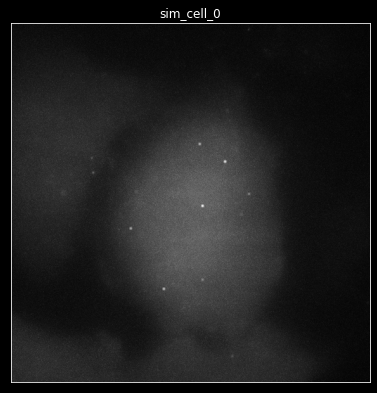

In [11]:
rsp.VisualizerImage(list_videos,list_files_names=list_files_names,selected_channel =0,selected_timepoint= 0,normalize=0,individual_figure_size=7).plot()

  0%|          | 0/1 [00:00<?, ?it/s]

mask time: 11  sec
tracking time: 3  sec
intensity calculation time: 1  sec


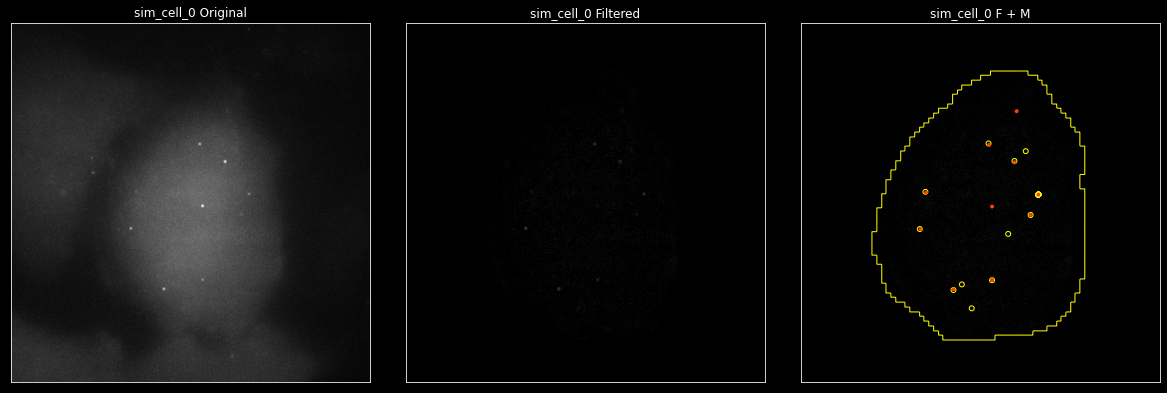

In [12]:
#intensity_selection_method =intensity_selection_method, mask_selection_method = mask_selection_method
list_DataFrame_particles_intensities= []
list_array_intensities = []
list_time_vector = []
for i in tqdm(range(0,nimg)): 
    DataFrame_particles_intensities, array_intensities, time_vector, mean_intensities,std_intensities, mean_intensities_normalized, std_intensities_normalized = rsp.PipelineTracking(list_videos[i],particle_size=particle_size,file_name=list_files_names[i],selected_channel=0,intensity_calculation_method =intensity_calculation_method, mask_selection_method = mask_selection_method,show_plot=1,use_optimization_for_tracking=use_optimization_for_tracking,real_positions_dataframe = list_df_real_positions[i],average_cell_diameter=200,print_process_times=1).run()    
    list_DataFrame_particles_intensities.append(DataFrame_particles_intensities)
    list_array_intensities.append(array_intensities)
    list_time_vector.append(time_vector)

In [18]:
# Dataframe from simulated data
num_particles_real = list_df_real_positions[0]['particle'].nunique()
print('number of particles:', num_particles_real , '\n')
list_df_real_positions[0]

number of particles: 10 



,Unnamed: 0,cell_number,particle,frame,red_int_mean,green_int_mean,blue_int_mean,red_int_std,green_int_std,blue_int_std,x,y
0,0,0,0,0,985.0,505.0,0.0,260.356383,135.908793,0.0,170.0,293.0
1,1,0,0,1,815.5,512.0,0.0,215.993911,137.494704,0.0,170.0,294.0
2,2,0,0,2,775.5,520.0,0.0,206.704040,140.538143,0.0,170.0,294.0
3,3,0,0,3,1094.5,498.5,0.0,287.098155,133.249504,0.0,168.0,293.0
4,4,0,0,4,142.0,509.0,0.0,7.054530,137.709259,0.0,168.0,293.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,0,9,15,333.5,150.0,0.0,79.338626,25.142029,0.0,307.0,124.0
196,196,0,9,16,579.0,149.0,0.0,150.951118,25.021463,0.0,307.0,124.0
197,197,0,9,17,190.0,155.0,0.0,25.289871,27.494989,0.0,307.0,125.0
198,198,0,9,18,91.0,158.5,0.0,3.135347,28.637430,0.0,306.0,125.0


In [19]:
# Dataframe from tracking
num_particles_tracking = list_DataFrame_particles_intensities[0]['particle'].nunique()
print('number of particles:',num_particles_tracking, '\n')
list_DataFrame_particles_intensities[0]

number of particles: 25 



,cell_number,particle,frame,red_int_mean,green_int_mean,blue_int_mean,red_int_std,green_int_std,blue_int_std,x,y
0,0,0,0,283.0,71.0,0.0,80.996553,29.865994,0.0,243.935288,406.829120
1,0,0,1,224.0,72.0,0.0,63.423100,32.721711,0.0,245.017888,404.482964
2,0,0,2,224.0,58.5,0.0,63.423100,33.332843,0.0,245.017888,404.482964
3,0,0,3,292.0,72.0,0.0,80.476024,32.721711,0.0,245.229808,404.134888
4,0,0,4,280.0,50.0,0.0,85.407316,27.920057,0.0,245.340535,404.774691
...,...,...,...,...,...,...,...,...,...,...,...
307,0,23,19,314.0,39.5,0.0,73.448213,18.920296,0.0,373.889009,190.567888
308,0,24,11,227.5,91.0,0.0,66.004412,32.886861,0.0,161.361053,261.657895
309,0,24,13,197.0,59.0,0.0,58.092010,27.321083,0.0,161.360465,261.659619
310,0,24,14,197.0,70.0,0.0,58.092010,30.211362,0.0,161.985992,261.898833


In [15]:
'''
for k in range (0,self.n_particles):
    frames_part =self.trackpy_dataframe.loc[self.trackpy_dataframe['particle']==self.trackpy_dataframe['particle'].unique()[k]].frame.values
    for j in range(0,len(frames_part)):
        for i in range(0,number_channels):
            current_frame = frames_part[j]
            try:
                x_pos=int(self.trackpy_dataframe.loc[self.trackpy_dataframe['particle']==self.trackpy_dataframe['particle'].unique()[k]].x.values[j])
                y_pos=int(self.trackpy_dataframe.loc[self.trackpy_dataframe['particle']==self.trackpy_dataframe['particle'].unique()[k]].y.values[j])
            except:
                x_pos=int(self.trackpy_dataframe.loc[self.trackpy_dataframe['particle']==self.trackpy_dataframe['particle'].unique()[k]].x.values[frames_part[0]])
                y_pos=int(self.trackpy_dataframe.loc[self.trackpy_dataframe['particle']==self.trackpy_dataframe['particle'].unique()[k]].y.values[frames_part[0]])
'''
                 

"\nfor k in range (0,self.n_particles):\n    frames_part =self.trackpy_dataframe.loc[self.trackpy_dataframe['particle']==self.trackpy_dataframe['particle'].unique()[k]].frame.values\n    for j in range(0,len(frames_part)):\n        for i in range(0,number_channels):\n            current_frame = frames_part[j]\n            try:\n                x_pos=int(self.trackpy_dataframe.loc[self.trackpy_dataframe['particle']==self.trackpy_dataframe['particle'].unique()[k]].x.values[j])\n                y_pos=int(self.trackpy_dataframe.loc[self.trackpy_dataframe['particle']==self.trackpy_dataframe['particle'].unique()[k]].y.values[j])\n            except:\n                x_pos=int(self.trackpy_dataframe.loc[self.trackpy_dataframe['particle']==self.trackpy_dataframe['particle'].unique()[k]].x.values[frames_part[0]])\n                y_pos=int(self.trackpy_dataframe.loc[self.trackpy_dataframe['particle']==self.trackpy_dataframe['particle'].unique()[k]].y.values[frames_part[0]])\n"

In [23]:
import itertools
list_idx_real = np.arange(0,num_particles_real,step=1)
list_idx_tracking = np.arange(0,num_particles_tracking,step=1)
combinations = list(itertools.product(list_idx_real,list_idx_tracking))
#combinations

In [17]:
from scipy.spatial.distance import pdist

In [ ]:
# https://stackoverflow.com/questions/31667070/max-distance-between-2-points-in-a-data-set-and-identifying-the-points/31667270#31667270
# https://stackoverflow.com/questions/31632190/measuring-geographic-distance-with-scipy
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist

In [24]:
import numpy as np
import random as rd
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

A = np.array([np.array([rd.randint(-5,5) for x in range(3)]) for y in range(500)])
D=pdist(A)
D=squareform(D)
temp = np.where(D == D.max())
temp_b = zip(temp[0],temp[1])

In [27]:
A

array([[-1,  2,  2],
       [-5,  0, -2],
       [ 4, -2,  4],
       ...,
       [-4, -5, -4],
       [ 0,  2,  1],
       [ 4,  1,  2]])